In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from simfinmodel import *

# Decoupling fundamentals

## Introduction
Based on Minsky’s evolution from Commercial Capitalism to Money Manager Capitalism, there is seems to have be another step in the evolution of capitalism. This change has taken place over the last two decades and Minsky would probably have coined the term “Index Capitalism”. 

More and more of the investment capital is moving into index management, near index management or following different quantitative algorithms (like momentum and mean reversion). According to JP Morgan only 10% of the trading volume today are done by fundamental investors. 

**How will this change the dynamics and ultimately the robustness of financial markets?**

The classic market mechanism is that investors have a view on the fundamental value of a company, and as the prices fall, the number of buyers increases as the price gets more attractive etc. This creates a form of self-stabilizing mechanism in the markets. 

In the index capitalism the majority of capital is following mechanical rules which are disconnected from the underlying investee companies. If the fundamental investors are too few and far between, their stabilizing effect on the financial markets will be marginal. 

Instead the market dynamics will be driven by the relative size of investment strategies (such as trend following and mean reversion) and the capital flows to and from index funds. In the past these factor were dominated by the fundamental investors. Market consequences of index capitalism The change in markets towards index capitalism is gradual, but at some point the system enters into a state where the chance of instability increases dramatically. 

* Instability: The system could become instable in some situations depending on the relative weighting between different trading strategies or due to the introduction of new trading strategies that are widely adapted. 
* Dynamics: With a greater disconnect between fundamental value of a stock and the stock market valuation, will lead to new type of dynamics on the financial markets. Increased correlation between stocks in same sector (despite different quality of stocks). Deviations from fair-value will be much longer and more persistent.
* Flows: With a large portion of pension and insurance money invested in index strategies, the flows (in and out of the index funds) will drive the stock market (at the beta level). Increasing the stocks covariation with the market. Sentiment driven flows will create large amounts of volatility. 

A decoupling of stock market dynamics from stock fundamentals will have a massive impact on how institutional investors should behave in the short- and medium-term as well as assessing extreme tail risk events. The market dynamics of index capitalism might explain why the realized return from absolute return strategies (such as long-short equities) have been going down.

The demise of fundamental investors also impacts the governance of listed corporates. Fewer investors are there to hold the executive management to account and bad companies will not quickly punished by the market. This leads to that problems will linger along and hampers long-term growth. What can investors do?

A good understanding of the new dynamics under index capitalism is necessary. Affects both alpha strategies as well as Strategic and Tactical allocation of market risks. Investors we need to be better at dealing with increased uncertainty. For example, have we passed the instability threshold and in that case what are good indicators to better manage the increased instability?

## The model

We model a stock market in which traders with heterogeneous expectations trade a risky asset on a limit-orderbook driven stock market. Traders form expectations about returns using a combination of fundamental, momentum, mean-reversion, buy-and-hold and randomized trading strategies.

LF traders calculate moving averages over two time horizons: the short moving average $q_x^1$, and the long moving average $q_x^2$. Additionally, each trader has a currently preferred strategy: mean reversion $s^u$, momentum $s^y$, or zero-intelligence $s^z$. A fundamental value which evolves according to an AR(1) process $r$ underlies the risky asset. 

The limit-order book $c$ is made up of a bids-book, $b_c$ and an asks-book $a_c$. The orderbook displays the best bid $o_{t,i}^{b*}$ and ask $o_{t,i}^{a*}$ type orders to all market participants. Orders $o$ contains information about the limit price $p_o$ volume $v_o$ and the agent $x_o$ which issued it.


### Simulation Sequence
Over the course of the simulation, the state variables of the agents are updated every period. Agents generally act in a random order. 

1. trader selection
2. expectation formation
3. order submission
4. 


This model is largely based on the Chiarelli and Iori 2002 model. Like in that model, all traders form expectations about stock returns by weighting several components. However, in this model, we added a mean reversion and buy-and-hold component to the existing fundamentalist, chartist, and random components. 

First a random selection of size, $\gamma_{a}$, is allowed to enter the market. For every agent entering the market, these weights are drawn from a random normal distribution: $w^mr \sim N(0, \sigma^{mr})$, $w^h \sim N(0, \sigma^h)$,, $w^f \sim N(0, \sigma^f)$, $w^c \sim N(0, \sigma^c)$, and $w^f \sim N(0, \sigma^f)$. Then, they are normalized.

Then each trader forms its expected return as:

\begin{equation}
\mathrm {E}_{lf,t}[r_{t+1}] = w^f \frac{p^f_t - p_t}{p_t} + w^c \bar{r} - w^{mr} \bar{r} +  + w^n \epsilon_t.
\end{equation}

Each trader then converts its expected return to an expected price by multiplying it by the current price:

\begin{equation}
\mathrm {E}_{lf,t}[p_{t+1}] = p_t \exp(\mathrm {E}_{lf,t}[r_{t+1}])
\end{equation}

The trader will submit a bid (ask) order of quantity $q \sim N(0, \sigma^q)$ if the price is lower (higher) than its expected price. The order price $o_t^{p}$ is placed near the best current order price,

\begin{equation}
o_t^p= o_t^{*} + \theta
\end{equation}

where, depending on whether the order is a bid or ask order, $o_t^{*}$ is the lowest ask price $o_t^{a*}$ or highest bid price $o_t^{b*}$ while $\theta \sim N(0, \sigma^{\theta})$ is negative for a bid order and positive for an ask order.

Like in \citet{schasfoort2017fundamentals}, after all orders have been sent, the limit-order book will match highest price bid, $o_t^b$, lowest price ask price and match them at the best ask price, 

\begin{equation}
o_t^{*, p}= o_t^{a*, p},
\end{equation}

and the volume of the lowest volume order,
\begin{equation}
o_t^{*, v}= min(o_t^{a*, v}, o_t^{b*, v}).
\end{equation}

Then, a transaction takes place. The bid owner $j$ transfers an amount of money $\Delta d_i$ to the ask holder $i$ and the ask owner transfers a number of stocks $\Delta h_j$ to the bid holder. 

\begin{equation}
\Delta d_i = o_t^{*, p} o_t^{*, v}.
\end{equation}

\begin{equation}
\Delta d_j = - \Delta d_i
\end{equation}

\begin{equation}
\Delta h_j = o_t^{*, v},
\end{equation}

\begin{equation}
\Delta h_i = - \Delta h_j
\end{equation}

This process repeats until there are no more bid or ask orders or the price of the best bid order is below the price of the best ask order, 

\begin{equation}
o_t^{b*, p} < o_t^{a*, p}.
\end{equation}

Orders expire after an x amount of ticks


## Parameters

In [12]:
NRUNS = 10
parameters = {
    # global parameters
    "n_traders": 5000,
    "ticks": 10000,
    "trader_sample_size": 4,
    "fundamental_value": 100,
    "std_fundamental": 0.08,
    "std_noise": 0.05,
    "std_vol": 4,
    "max_order_expiration_ticks": 50,
    # trader parameters
    "w_fundamentalists": 0.0,
    "w_momentum": 0.0,
    "w_random": 10.0,
    "w_mean_reversion": 80.0,
    "w_buy_hold": 10.0,
    "spread_max": 0.25, 
    "horizon_min": 2,
    "horizon_max": 8,
}

## Baseline Monte Carlo Simulations

In [13]:
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(parameters)
    traders, orderbook = sim_fin_model(traders, orderbook, parameters, seed)
    traders.append(traders)
    obs.append(orderbook)

## Dynamics

In [14]:
def organise_data(obs):
    window = 20
    close_price = []
    returns = []
    autocorr_returns = []
    autocorr_abs_returns = []
    returns_volatility = []
    volume = []
    fundamentals = []
    for ob in obs: # record
        # close price
        close_price.append(ob.tick_close_price)
        # returns
        r = pd.Series(np.array(ob.tick_close_price)).pct_change()
        returns.append(r)
        # autocorrelation returns
        ac_r = [r.autocorr(lag=lag) for lag in range(25)]
        autocorr_returns.append(ac_r)
        # autocorrelation absolute returns
        absolute_returns = pd.Series(r).abs()
        autocorr_abs_returns.append([absolute_returns.autocorr(lag=lag) for lag in range(25)])
        # volatility of returns
        roller_returns = r.rolling(window)
        returns_volatility.append(roller_returns.std(ddof=0))
        # volume
        volume.append([sum(volumes) for volumes in ob.transaction_volumes_history])
        # fundamentals 
        fundamentals.append(ob.fundamental)
    mc_prices = pd.DataFrame(close_price).transpose()
    mc_returns = pd.DataFrame(returns).transpose()
    mc_autocorr_returns = pd.DataFrame(autocorr_returns).transpose()
    mc_autocorr_abs_returns = pd.DataFrame(autocorr_abs_returns).transpose()
    mc_volatility = pd.DataFrame(returns_volatility).transpose()
    mc_volume = pd.DataFrame(volume).transpose()
    mc_fundamentals = pd.DataFrame(fundamentals).transpose()
    
    return mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals

In [15]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

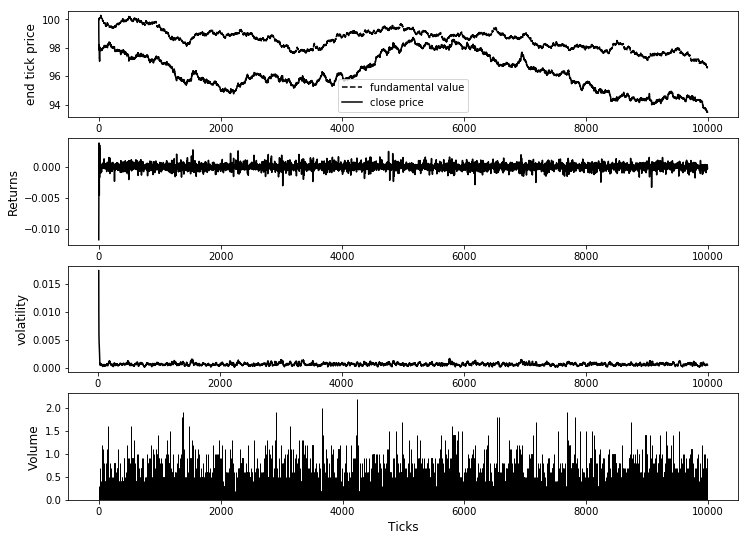

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend()

ax2.plot(mc_returns.index, mc_returns.mean(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-')
ax3.set_ylabel('volatility', fontsize='12')

ax4.bar(mc_volume.index, mc_volume.mean(axis=1), color='k', edgecolor='k')
ax4.set_ylabel('Volume', fontsize='12')
ax4.set_xlabel('Ticks', fontsize='12')

# for ax in [ax1, ax2, ax3, ax4]:
#     ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# Basic stylized facts

* **No autocorrelation** in returns
* **Volatility clustering** (marked by slowly decaying absolute autocorrelation)

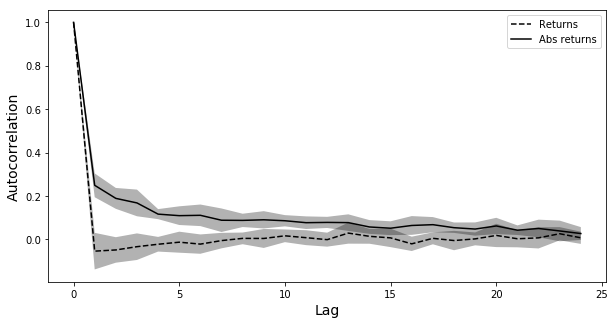

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

* **Excess Kurtosis**

In [89]:
mc_prices.mean(axis=1).kurtosis()

0.24756863345884961

# Experiments

Index capitalism means a move from fundamentalist trading strategies to passive index following strategies. 

We simulate two scenarios:
1. Most technical traders are momentum traders
2. Most technical traders are mean reversion traders

Test effects on deviation from fundamentals and market volatility. 

In [90]:
parameters["w_fundamentalists"] = 10.0
parameters["w_buy_hold"] = 40.0
# experiment 1
parameters["w_momentum"] = 30.0
parameters["w_mean_reversion"] = 0.0
traders1 = []
obs1 = []
for seed in range(NRUNS): 
    trader1, orderbook1 = init_objects(parameters)
    trader1, orderbook1 = sim_fin_model(trader1, orderbook1, parameters, seed)
    traders1.append(trader1)
    obs1.append(orderbook1)
# experiment 2
parameters["w_momentum"] = 0.0
parameters["w_mean_reversion"] = 30.0
traders2 = []
obs2 = []
for seed in range(NRUNS): 
    trader2, orderbook2 = init_objects(parameters)
    trader2, orderbook2 = sim_fin_model(trader2, orderbook2, parameters, seed)
    traders2.append(trader2)
    obs2.append(orderbook2)

In [91]:
mc_prices1, mc_returns1, mc_autocorr_returns1, mc_autocorr_abs_returns1, mc_volatility1, mc_volume1, mc_fundamentals1 = organise_data(obs1)

In [92]:
mc_prices2, mc_returns2, mc_autocorr_returns2, mc_autocorr_abs_returns2, mc_volatility2, mc_volume2, mc_fundamentals2 = organise_data(obs2)

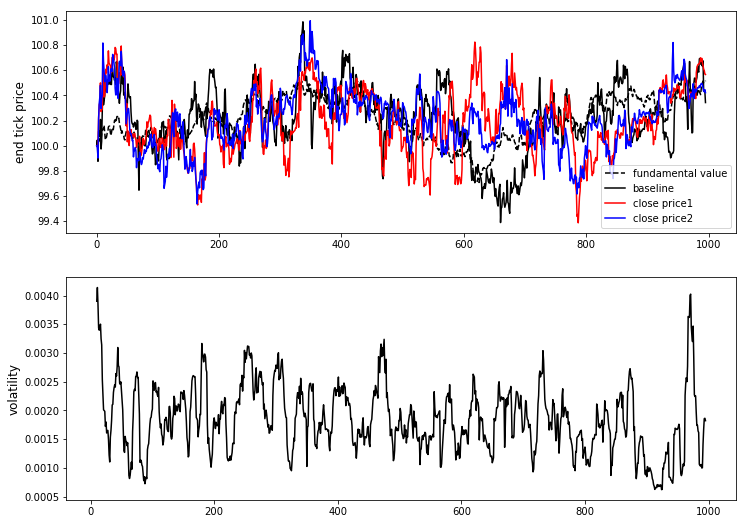

In [100]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))

ax1.plot(mc_fundamentals1.index, mc_fundamentals1.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k-', label='baseline')
ax1.plot(mc_prices1.index, mc_prices1.mean(axis=1), 'r-', label='close price1')
ax1.plot(mc_prices2.index, mc_prices2.mean(axis=1), 'b-', label='close price2')
ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend()


ax2.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-')
ax2.set_ylabel('volatility', fontsize='12')


In [99]:
print(mc_prices.median(axis=1).std())
print(mc_prices1.median(axis=1).std())
print(mc_prices2.median(axis=1).std())

0.40703206850386675
0.4547531616934812
0.44623738350717274


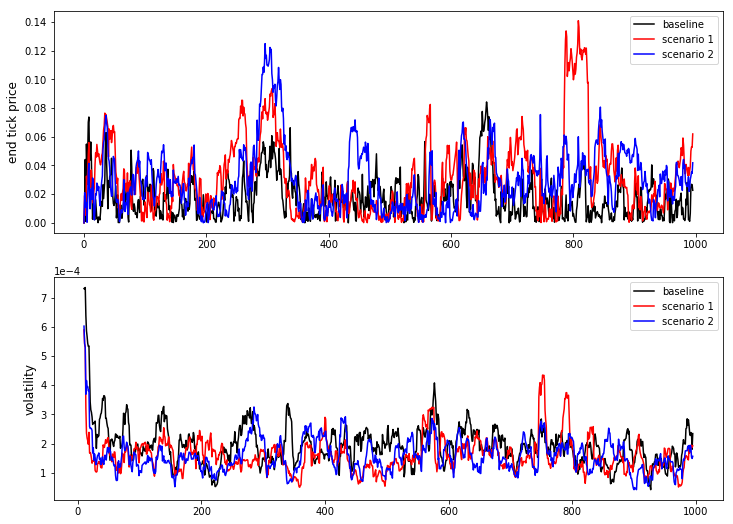

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))

ax1.plot(mc_fundamentals1.index, abs(mc_prices.mean(axis=1)-mc_fundamentals.mean(axis=1)), 'k-', label='baseline')
ax1.plot(mc_fundamentals1.index, abs(mc_prices1.mean(axis=1)-mc_fundamentals1.mean(axis=1)), 'r-', label='scenario 1')
ax1.plot(mc_fundamentals2.index, abs(mc_prices2.mean(axis=1)-mc_fundamentals2.mean(axis=1)), 'b-', label='scenario 2')

#ax1.plot(mc_prices1.index, mc_prices1.mean(axis=1), 'k-', label='close price1')
ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend()

ax2.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-', label='baseline')
ax2.plot(mc_volatility1.index, mc_volatility1.mean(axis=1), 'r-', label='scenario 1')
ax2.plot(mc_volatility2.index, mc_volatility2.mean(axis=1), 'b-', label='scenario 2')
ax2.set_ylabel('volatility', fontsize='12')
ax2.legend()

for ax in [ax1, ax2]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))